# GSoC 2020 ATLAS Autoencoder Evaluation Task

## Data Exploration

In [0]:
import numpy as np
import pickle as pkl
import pandas as pd

In [0]:
# load train and test dataset from pkl files
with open('/content/drive/My Drive/all_jets_test_4D_100_percent.pkl', 'rb') as file:
    test = pd.DataFrame(pkl.load(file))

with open('/content/drive/My Drive/all_jets_train_4D_100_percent.pkl', 'rb') as file:
    train = pd.DataFrame(pkl.load(file))

n_features = len(train.loc[0]) # get feature number (here is 4)

# normalize the train and test dataset to standard one (std=1)
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

print("---------- After Norm ----------")
print(test.head())
print(test.describe())

print(train.head())
print(train.describe())

                   m             pt       phi       eta
85972    4983.729980   23798.070312  1.962157 -0.059532
38742    5435.273438   21881.867188  1.035412  0.734343
128711   5239.408691   24608.134766 -1.121055  0.828848
28751   14121.240234  203110.953125  0.324205 -2.571108
131358   3344.826660   24897.294922  0.395331  1.440069
                   m             pt           phi           eta
count   27945.000000   27945.000000  27945.000000  27945.000000
mean     8953.467169   65082.072456      0.007022      0.040346
std      7484.942144   71586.689016      1.813966      1.439198
min        -0.045315   20000.074219     -3.141492     -4.782808
25%      4662.796387   22493.634766     -1.566266     -1.134387
50%      5711.495117   27151.828125      0.028218      0.070660
75%     10511.995117   79948.820312      1.571245      1.176707
max    114533.429688  786146.937500      3.141527      4.658744
                   m             pt       phi       eta
132784   3831.839355   22000.609

## Network

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import basic_train, basic_data
from fastai.callbacks import ActivationStats
from fastai import train as tr
import fastai

In [0]:
class AE_3D_200(nn.Module):
    """
    An Autoencoder that compresses 4d vectors into 3d vectors. The encode-decode process is in-200-100-50-3-50-100-200-out.
    """

    def __init__(self, n_features=4):
        """
        Initialize the autoencoder network, and define the layers.
        input:
        - n_features:int=4  The dimension of input feature, by default is 4.
        """
        super(AE_3D_200, self).__init__()
        self.en1 = nn.Linear(n_features, 200) # the 1st encoding layer, a fully-connected layer with {n_features}-d input (raw data) and 200d output 
        self.en2 = nn.Linear(200, 100) # the 2nd encoding layer, a fully-connected layer with 200d input and 100d output
        self.en3 = nn.Linear(100, 50) # the 3rd encoding layer, a fully-connected layer with 100d input and 50d output
        self.en4 = nn.Linear(50, 3) # the last encoding layer, a fully-connected layer with 50d input and 3d output as encoded data

        self.de1 = nn.Linear(3, 50) # the 1st decoding layer, a fully-connected layer with 3d input (encoded data) and 50d output 
        self.de2 = nn.Linear(50, 100) # the 2nd decoding layer, a fully-connected layer with 50d input and 100d output 
        self.de3 = nn.Linear(100, 200) # the 3rd decoding layer, a fully-connected layer with 100d input and 200d output 
        self.de4 = nn.Linear(200, n_features) # the last decoding layer, a fully-connected layer with 200d input and {n_features}-d output (decoded data)
        self.tanh = nn.Tanh() # the activation funcition, with a range in (-1, 1)

    def encode(self, x):
        """
        Encode raw data into encoded ones.
        input:
        - x:torch.tensor(dtype=torch.float32) The raw data that need to be encode
        output:
        - out:torch.tensor(dtype=torch.float32) The encoded data
        """
        x = self.tanh(self.en1(x)) # encode: 4d => 200d 
        x = self.tanh(self.en2(x)) # encode: 200d => 100d
        x = self.tanh(self.en3(x)) # encode: 100d => 50d
        out = self.en4(x) # encode: 50d => 3d
        return out

    def decode(self, x):
        """
        Decode data into decoded ones.
        input:
        - x:torch.tensor(dtype=torch.float32) The raw data that need to be decode
        output:
        - out:torch.tensor(dtype=torch.float32) The decoded data
        """
        x = self.de1(self.tanh(x)) # deocde: 3d => 50d
        x = self.de2(self.tanh(x)) # deocde: 50d => 100d
        x = self.de3(self.tanh(x)) # deocde: 100d => 200d
        out = self.de4(self.tanh(x)) # deocde: 3d => 50d
        return out

    def forward(self, x):
        """
        Feed forward process of training.
        input:
        - x:torch.tensor(dtype=torch.float32) The raw data
        output:
        - out:torch.tensor(dtype=torch.float32) The decoded data
        """
        z = self.encode(x)
        return self.decode(z)

In [0]:
def get_data(train_ds, valid_ds, bs):
    """
    Dataloader wrapper of dataset.
    input:
    - train_ds:torch.tensor(dtype=torch.float32) The train dataset
    - valid_ds:torch.tensor(dtype=torch.float32) The test dataset
    - bs:int The size of batch
    output:
    - out:turple A turple of train shuffled dataloader with a batchsize in bs, and test dataloader with a batchsize in 2*bs
    """
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [0]:
# The input data and the ground true of encode-deocded data is the same (raw data),
# so the x (input data) and y (ground) are the copy of raw data.
train_x = train
test_x = test
train_y = train_x
test_y = test_x

# Construct dataset, the data type should be declare explicitly as torch.float (torch.float32).
# The original code does not declare, so the data
# will be converted to torch.double (torch.float64) and lead to datatype error when encoding.
#train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values)) 
#valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

# Get dataloader
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

for data in train_ds:
    print(data)
    break

(tensor([-0.6885, -0.6076,  0.8681,  0.7590]), tensor([-0.6885, -0.6076,  0.8681,  0.7590]))


In [0]:
# Bind train_dl and test_dl in a data object.
db = basic_data.DataBunch(train_dl, valid_dl)

model = AE_3D_200() # Instantiate the model implemented above

loss_func = nn.MSELoss() # Use mean squared error (squared L2 norm) as loss function

bn_wd = False  # Don't use weight decay for batchnorm layers
true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6 # set the value of weight decay

# Define the learner in Fast.ai, with a record of the mean and std of activation func (enabled by ActivationStats)
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

# train model again instead of loading from file
#Choose the trained network here, loads from models/
#learn.load('AE_3D_200_no1cycle_trainforever')

model.to('cpu')

AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 3.98E-03


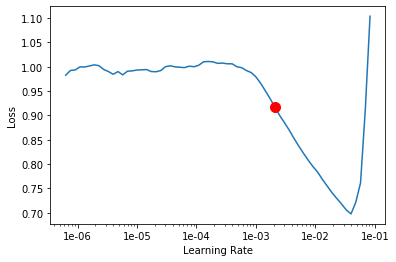

In [0]:
# find the best learning rate (marked as rad dot in the image)
tr.lr_find(learn)
learn.recorder.plot(suggestion=True)

In [0]:
lr = 3e-3
#learn.fit(100, lr=lr, wd=wd)
learn.fit_one_cycle(100, lr, wd=wd) # use fit_one_cycle to train the model, which has more flexible lr and wd control.

epoch,train_loss,valid_loss,time
0,0.052020,0.049398,00:05
1,0.033223,0.036096,00:05
2,0.032910,0.034164,00:05
3,0.030777,0.032956,00:05
4,0.030581,0.032320,00:05
5,0.029691,0.031534,00:05
6,0.030118,0.030748,00:05
7,0.028211,0.030622,00:05
8,0.029446,0.030118,00:05
9,0.026113,0.026360,00:05


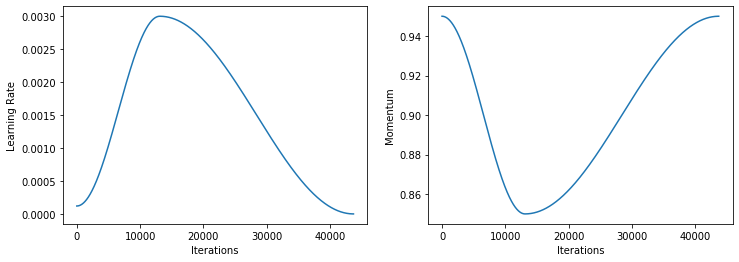

In [0]:
# show the change of lr and mom during training process
learn.recorder.plot_lr(show_moms=True)

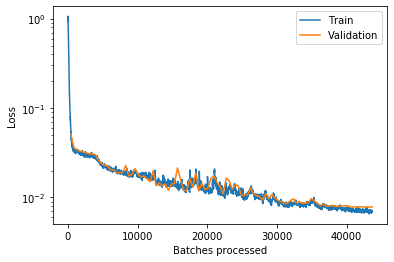

In [0]:
# show the change of loss every batch 
learn.recorder.plot_losses()
plt.yscale('log')

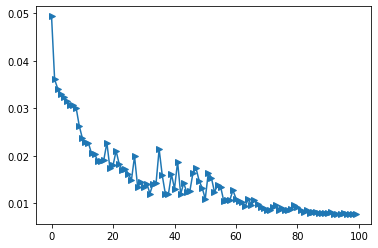

In [0]:
# show the test loss alone
plt.plot(learn.recorder.val_losses, marker='>')

In [17]:
# decrese the lr and train again
lr = 1e-5
#learn.fit(200, lr=lr, wd=wd)
learn.fit_one_cycle(200, lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.006956,0.007816,00:05
1,0.007211,0.007816,00:05
2,0.006919,0.007815,00:05
3,0.006923,0.007816,00:05
4,0.006922,0.007815,00:05
5,0.006762,0.007814,00:05
6,0.006921,0.007814,00:06
7,0.007014,0.007812,00:05
8,0.007334,0.007814,00:05
9,0.006762,0.007813,00:05


Buffered data was truncated after reaching the output size limit.

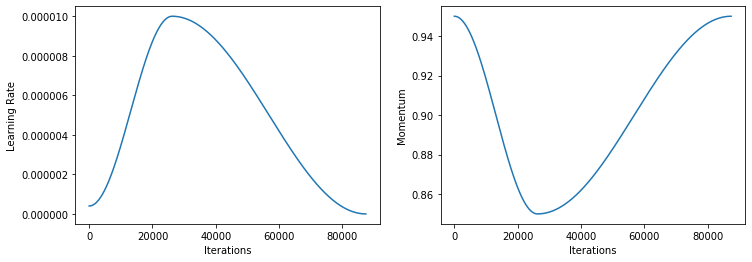

In [18]:
learn.recorder.plot_lr(show_moms=True)

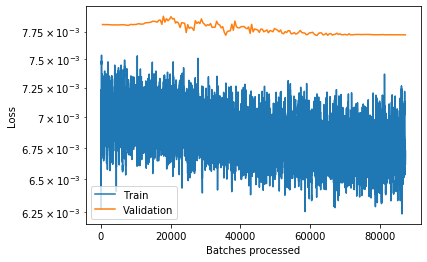

In [19]:
learn.recorder.plot_losses()
plt.yscale('log')

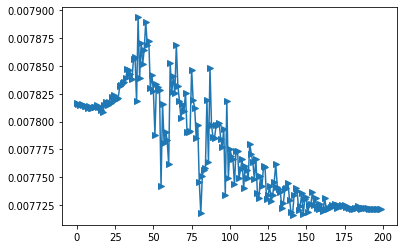

In [20]:
plt.plot(learn.recorder.val_losses, marker='>')

In [21]:
# save the trained model to drive
learn.save("/content/drive/My Drive/trained_ae_50", return_path=True)

PosixPath('/content/drive/My Drive/trained_ae_50.pth')

In [0]:
def plot_activations(learn, figsize=(12, 9), lines=['-', ':'], save=None, linewd=1, fontsz=14):
    """
    Show the change of activation function (mean and std) during training.
    input:
    - learn:fastai.basic_train.Learner The learner after training
    - figsize:turple The turple (H*W) indicates the figure size
    - lines:list The list of line styles
    - save:bool Save the image or not
    - linewd:int the width of line
    - fontz:int font size
    """
    plt.figure(figsize=figsize)

    # plot the mean of each activation function 
    for i in range(learn.activation_stats.stats.shape[1]):
        #thiscol = ms.colorprog(i, learn.activation_stats.stats.shape[1])
        plt.plot(learn.activation_stats.stats[0][i], linewidth=linewd, 
            label=str(learn.activation_stats.modules[i]).split(',')[0], linestyle=lines[i % len(lines)])
    
    plt.title('Weight means')
    plt.xlabel('Mini-batch')
    plt.legend(fontsize=fontsz)

    if save is not None:
        plt.savefig(save + '_means')

    plt.figure(figsize=figsize)

    # plot the std of each activation function 
    for i in range(learn.activation_stats.stats.shape[1]):
        #thiscol = ms.colorprog(i, learn.activation_stats.stats.shape[1])
        plt.plot(learn.activation_stats.stats[1][i], linewidth=linewd, 
            label=str(learn.activation_stats.modules[i]).split(',')[0], linestyle=lines[i % len(lines)])
    
    plt.title('Weight standard deviations')
    plt.xlabel('Mini-batch')
    plt.legend(fontsize=fontsz)

    if save is not None:
        plt.savefig(save + '_stds')

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


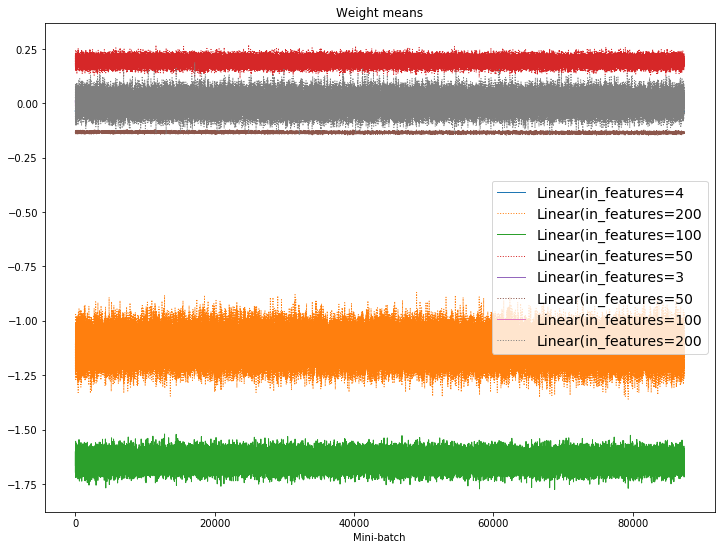

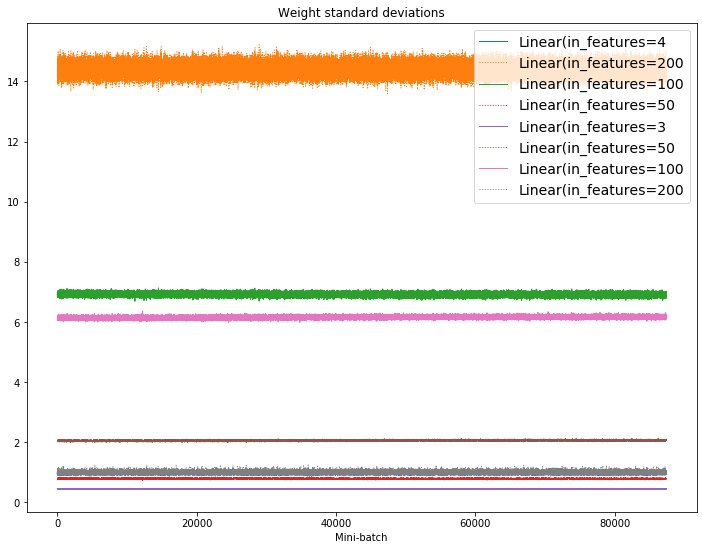

In [23]:
plot_activations(learn)

In [24]:
learn.validate() # print current test loss

[0.00772147]

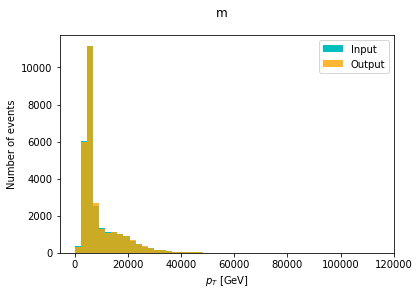

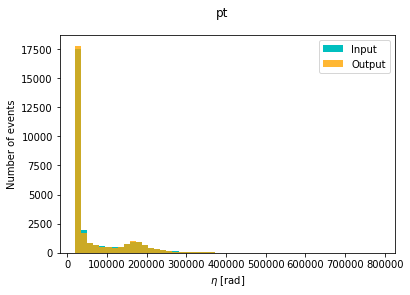

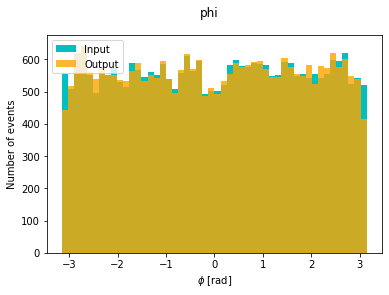

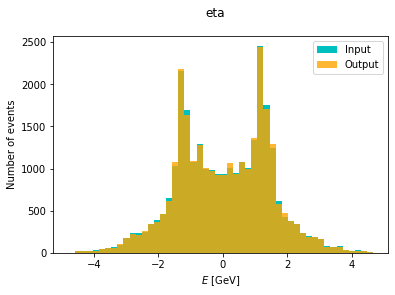

In [25]:
# Compare the distribution of each dimension of the raw data and decoded data, the closer the better
# the raw data is shown in clay while the encoded ones is in orange.

plt.close('all') # close all image

# define the label of x/y-axis, line sytle, colors and markers
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

idxs = (0, 100000)  # only compare the first 100,000 jets

# get raw data and decoded data
data = torch.tensor(test_x[idxs[0]:idxs[1]].values, dtype=torch.float)
pred = model(data).detach().numpy()

# recover them to not normalized by (data * std + mean)
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8 # the transparency of histogram
n_bins = 50 # the number of equal-width bins in the range

for kk in np.arange(4):
    plt.figure(kk + 4)

    # draw raw data in the plot
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    # draw decoded data in the plot with a transparency in 0.8
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    plt.legend()

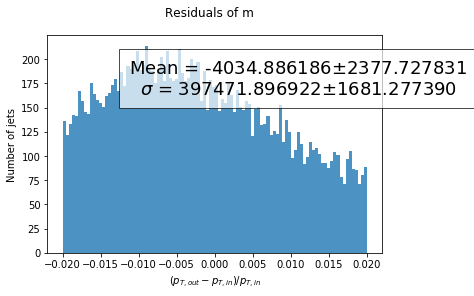

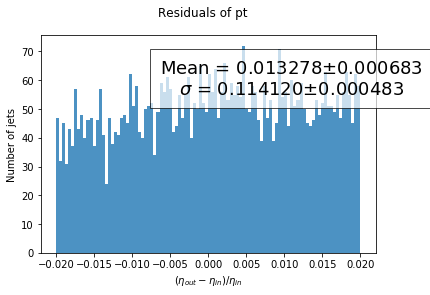

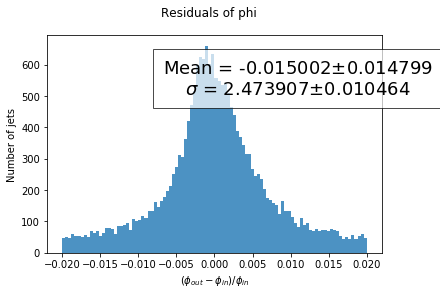

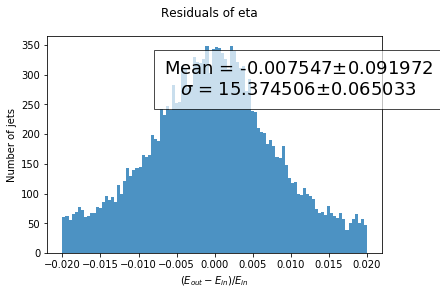

In [26]:
from scipy import stats


def std_error(x, axis=None, ddof=0):
    """
    Compute the standard error of x along the specified axis, while ignoring NaNs.
    input:
    - x:numpy.array 
    - axis:int or None Axis or axes along which the standard deviation is computed.
    - ddof:int Delta Degrees of Freedom
    output:numpy.array standard error of x
    """
    return np.nanstd(x, axis=axis, ddof=ddof) / np.sqrt(2 * len(x))

# define the label of x/y-axis, line sytle, colors and markers
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
            r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
            r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
            r'$(E_{out} - E_{in}) / E_{in}$']

# calculate residuals
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
range = (-.02, .02)

# show the distribution of residuals of each dimension
for kk in np.arange(4):
    plt.figure()

    # plot residuals
    n_hist_pred, bin_edges, _ = plt.hist(residuals[:, kk], label='Residuals', 
                        linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])
    plt.ylabel('Number of jets')

    # calcualte the stat metrics
    std = np.std(residuals[:, kk])
    std_err = std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()

    # label the distribution (mean and std) of residuals
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), 
             bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10}, horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes, fontsize=18)
    
    fig_name = 'trainforever_residual_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

In [27]:
!pip install corner

  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11642 sha256=e3dff82753301fc019a7ba23d95d9f85917d6a70a36517f5015c31cbbe869370
  Stored in directory: /root/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner


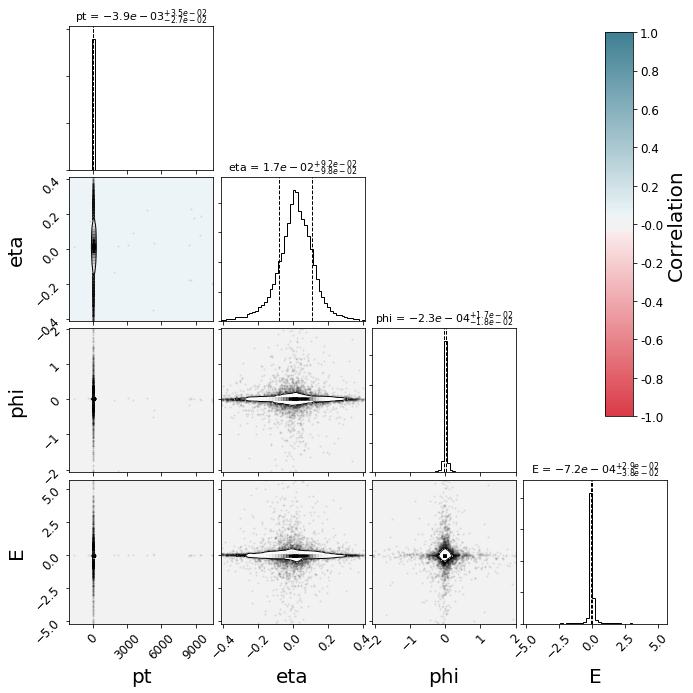

In [28]:
import corner.corner as corner
import seaborn as sns


# generate the residuals dataframe of each dim
res_df = pd.DataFrame({'pt': residuals[:, 0], 'eta': residuals[:, 1], 'phi': residuals[:, 2], 'E': residuals[:, 3]})
save = False


cmap = sns.diverging_palette(10, 220, as_cmap=True) # Generate a custom diverging colormap
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False) # set the normalization to (-1, 1)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap) # scalar data to RGBA mapping

# set label and font size
group = ['pt', 'eta', 'phi', 'E']
label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]

# visualize a two dimensional data using a scatterplot matrix
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False,
                bins=50, labels=group, label_kwargs=label_kwargs,
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
linecol = 'r'
linstyl = 'dashed'

# set the colors of each plot according to correlation
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi])) # set color

# set the color label bar
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = 'corner_3d.png'
    plt.savefig(curr_save_folder + fig_name)